# Multiple Workspaces "Spray" - performance testing 
This notebook can be used for Regression testing and Blind testing in projects where multiple-workspaces (multiple-skills) are used. 

**Warning: this notebook evaluates the SPRAY method**: each testing phrase is evaluated by each sub-workspace/skill individually. <br>It might not be suitable for projects that are using ROUTER or WATERFALL method based on the <a href="https://medium.com/ibm-watson/ibm-watson-conversation-multiple-workspace-orchestration-d51f003f5d11">terminology of this blog </a>

### The Scope 
1. **Regression Test Scope**: This can be used to test a set of testing phrases that are not part of the training set in Watson Assistant (WA). The idea is that you would re-run this test over time after the improvement phase, to check the health status of your workspace, and make sure that the workspace is still behaving in a consistent manner. 
2. **Blind Test Scope**: Simply analyse a set of testing phrases that are not part of the training set in Watson Assistant. This can be a one-off task requested by stakeholders. 

Either way, the procedure to obtain the results is the same in both cases. The difference is the scope and the content of your testing set.  

<img src="images/data_flow1.png" style="width: 1000px;">


<div class="alert alert-block alert-info">
<b>Notebook Summary</b>
<br>
      
1. <b>Connect to WA</b> : credentials to connect to the right WA workspace<br>
2. <b>Feed your test set</b> : feed your regression test in a .csv format<br>
3. <b>Run the blind test</b> : send the testing phrases to WA workspace <br>
4. <b>Analyse the results</b> : calculate the metrics and confusion matrix<br>
5. <b>Analyse the incorrect matches</b> : highlight the phrases that did not trigger the right intent  
</div>


## Libraries

In [2]:
!pip install msgpack
!pip install watson-developer-cloud
import json 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
# import seaborn as sns
from watson_developer_cloud import AssistantV1
from IPython.display import display
from sklearn.metrics import *
import itertools

You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## 1. Connect to WA 

<div class="alert alert-block alert-warning">

<b>Data needed from the user</b>
<br>

    
1. <b>Credentials to connect to WA</b> : Log in to IBM cloud, Go to your resource list, select your WA service, and Click Show Credentials - based on what credentials you have, choose option1 (IAM) or option2 (Basic) to connect to your WA instance.<br>
2. <b>Multiple Workspaces</b> : the IDs of the workspaces that you want to analyse. - Go to your WA instance, "Skills" tab, click on the three dots of the workspace/skill that you are interested, choose "View API details" and you will find the Workspace ID
</div>

1. **IAM token**: With some service instances, you authenticate to the API by using **Identity and Access Management (IAM)** - (IBM Cloud is migrating to token-based IAM authentication). You will need `API Key`, `url` and `version`
2. **Basic Authentication**: In other instances, you authenticate by providing the **username and password** for the service instance. You will need `username`, `password`, `url` and `version`

**Option 1 - IAM token**

In [ ]:
assistant = AssistantV1(
    iam_apikey='',  #USER INPUT
    version='2018-07-10',  #USER INPUT
    url= '') #USER INPUT  
    # e.g. Frankfurt : 'https://gateway-fra.watsonplatform.net/assistant/api'
    # e.g. US-South : 'https://gateway.watsonplatform.net/assistant/api'

multi_workspace = ['',
                   '', 
                   '',
                   ''] #USER INPUT

**Option 2 - Basic Authentication**

In [3]:
assistant = AssistantV1(
    username='',  #USER INPUT
    password='', #USER INPUT
    version='2018-07-10',  #USER INPUT
    url= '') #USER INPUT  
    # e.g. Frankfurt : 'https://gateway-fra.watsonplatform.net/assistant/api'
    # e.g. US-South : 'https://gateway.watsonplatform.net/assistant/api'

multi_workspace = ['',
                   '', 
                   '',
                   ''] #USER INPUT

## 2. Feed the regression test

<div class="alert alert-block alert-warning">

<b>Data needed from the user</b>
<br>

    
1. <b>CSV file</b> : the regression test file containing the text and the predicted intent in a .csv format -> column A named : "text" and column B named: "intent" (UTF-8 format)<br>
2. <b>Threshold</b>: this is the minimum level of confidence level that you are expecting in order to check if the input text is triggering the right intent. For example, if the threshold = 0.40 and the input phrase is triggering the correct intent with only 35% of confidence level, we would want to count it as a False Positive (not meeting the required conditions) and not as a True Positive, despite the intent is correct. The default in WA is 0.2. Less than 20% the utterance is classified as `irrelevant`. However, if you need to have a higher threshold it can be set here. 
</div>


In [4]:
df = pd.read_csv("./test_set/multiws_reg_test.csv") #USER INPUT

threshold = 0.5 #USER INPUT

## 3. Run the Blind test 
We are sending each testing phrase to each WA and we are recording the first intent triggered with the respective confidence levels in a python dictionary that is stored in a dataframe. 

In [6]:
def multiws_blind_test(df):
    """
    This function will take the regression test set uploaded in csv format and 
    will send each test phrase to WA and collect information on how the system responded. 
    
    Parameter: 
        df: the regression_test in csv format

    Return: 
        results: a Pandas dataframe with `original text`, `predicted intent`, `predicted_ws` and also the results from WA
    """
    lst = [] # list of dictionary that I am creating 
    results = pd.DataFrame(columns=['original_text','predicted_ws','predicted_intent'])
    
    print("START TESTING")
    
    # for each row of the df dataframe
    for i in range(len(df)):  

        text = df["text"][i]
        print("\n"+ text, end = " " )
        results = results.append({
                'original_text': df["text"][i],
                'predicted_ws': df["workspace_id"][i],
                'predicted_intent': df["intent"][i],
            }, ignore_index=True)
        
        # send one sentence to each workspace 
        for j in range(len(multi_workspace)):
            response = assistant.message(workspace_id=multi_workspace[j], input={'text': text}, alternate_intents= True)
            dumps = json.dumps(response.get_result(), indent=2)

            data = json.loads(dumps)
            
            # take notes of the first intent and confidence level 
            intent1= data['intents'][0]['intent']
            confidence1 = data['intents'][0]['confidence'] 
            
            # put everything into a dictionary and collect all the dictionary into a list 
            dct = {"intent": intent1, "confidence": confidence1, "workspace": multi_workspace[j]}
            lst.append(dct)
            print('.',end='') # loading status...
            
        
        # put in the dataframe the retults that you collected 
        for y in range(len(lst)):
            results.loc[results.index[i], 'ws_{}'.format(y+1)] = [lst[y]]
        
        # find the best perfomring intent & workspace  
        loc_max, intent_max, ws_max = get_max(lst)
        
        # create the column: max_condifence
        results.loc[results.index[i], 'max_confidence'] = [{"intent": intent_max, "confidence": loc_max, "workspace": ws_max}]
        
        # create the columns: correct_ws and correct_intent
        if (results["predicted_ws"][i] == ws_max):
            results.loc[results.index[i], 'correct_ws'] = 1
            if (loc_max >threshold and results["predicted_intent"][i] == intent_max ): 
                results.loc[results.index[i], 'correct_intent'] = 1
            else: 
                results.loc[results.index[i], 'correct_intent'] = 0
        else:
            results.loc[results.index[i], 'correct_ws'] = 0
            results.loc[results.index[i], 'correct_intent'] = 0
        
        lst=[] # clear the list and start with the next sentence 
    
    results.to_csv("./results/multi_workspace/multiws_blind_test_results.csv", encoding='utf-8', index=False)
    
    print("\n")
    print("FINISHED")
    
    return results



def get_max(list_ws):
    """
    This function will find the maximum value od Confidence levels inside a list 
    """
    loc_max = 0.00
    for item in list_ws:
        for key,val in item.items():
            confidence = float(item['confidence'])
            intent = item['intent']
            ws = item['workspace']
            if confidence > loc_max:
                loc_max = confidence
                intent_max = intent 
                ws_max = ws 
    
    return loc_max, intent_max, ws_max


results = multiws_blind_test(df)
results.head(10)

START TESTING

I would like to order a pizza ....
where I am right now ....
tell me your name ....
mission to Mars ....
I am going to miss you ....
I am going to miss my dog ....
I want rucola on top  ....
is it possible to have ricotta salata ....

FINISHED


original_text  \
0          I would like to order a pizza   
1                   where I am right now   
2                      tell me your name   
3                        mission to Mars   
4                 I am going to miss you   
5              I am going to miss my dog   
6                  I want rucola on top    
7  is it possible to have ricotta salata   

                           predicted_ws   predicted_intent  \
0  347da87c-8823-4aea-9d3f-b441ea8c31e5              pizza   
1  347da87c-8823-4aea-9d3f-b441ea8c31e5           location   
2  347da87c-8823-4aea-9d3f-b441ea8c31e5  General_About_You   
3  347da87c-8823-4aea-9d3f-b441ea8c31e5            mission   
4  347da87c-8823-4aea-9d3f-b441ea8c31e5     General_Ending   
5  347da87c-8823-4aea-9d3f-b441ea8c31e5     General_Ending   
6  347da87c-8823-4aea-9d3f-b441ea8c31e5           toppings   
7  347da87c-8823-4aea-9d3f-b441ea8c31e5           toppings   

                                                ws_1  \
0  {'intent': 'pizza', 'confidence': 0.9907717704...   
1  {'intent': 'location', 'confidence': 0.8985697...   
2  {'intent': 'General_About_You', 'confidence': ...   
3  {'intent': 'mission', 'confidence': 0.81527824...   
4  {'intent': 'General_Ending', 'confidence': 0.7...   
5  {'intent': 'General_Ending', 'confidence': 0.4...   
6  {'intent': 'General_Ending', 'confidence': 0.5...   
7  {'intent': 'pizza', 'confidence': 0.3522557973...   

                                                ws_2  \
0  {'intent': 'locate_amenity', 'confidence': 0.9...   
1  {'intent': 'locate_amenity', 'confidence': 0.7...   
2  {'intent': 'off_topic', 'confidence': 0.944794...   
3  {'intent': 'goodbyes', 'confidence': 0.0852557...   
4  {'intent': 'goodbyes', 'confidence': 0.9581634...   
5  {'intent': 'off_topic', 'confidence': 0.460549...   
6  {'intent': 'turn_on', 'confidence': 0.40934834...   
7  {'intent': 'locate_amenity', 'confidence': 0.3...   

                                                ws_3  \
0  {'intent': 'orderRequest', 'confidence': 0.418...   
1  {'intent': 'branchClosure', 'confidence': 0.35...   
2  {'intent': 'chitChatConversation', 'confidence...   
3  {'intent': 'niceDayReply', 'confidence': 0.273...   
4  {'intent': 'chitChatConversation', 'confidence...   
5  {'intent': 'chitChatConversation', 'confidence...   
6  {'intent': 'increase', 'confidence': 0.3344546...   
7  {'intent': 'chitChatConversation', 'confidence...   

                                                ws_4  \
0  {'intent': 'orderRequest', 'confidence': 0.419...   
1  {'intent': 'branchClosure', 'confidence': 0.35...   
2  {'intent': 'chitChatConversation', 'confidence...   
3  {'intent': 'chitChatConversation', 'confidence...   
4  {'intent': 'chitChatConversation', 'confidence...   
5  {'intent': 'struggling', 'confidence': 0.29607...   
6  {'intent': 'increase', 'confidence': 0.3575446...   
7  {'intent': 'statement', 'confidence': 0.331102...   

                                      max_confidence  correct_ws  \
0  {'intent': 'pizza', 'confidence': 0.9907717704...         1.0   
1  {'intent': 'location', 'confidence': 0.8985697...         1.0   
2  {'intent': 'General_About_You', 'confidence': ...         1.0   
3  {'intent': 'mission', 'confidence': 0.81527824...         1.0   
4  {'intent': 'goodbyes', 'confidence': 0.9581634...         0.0   
5  {'intent': 'off_topic', 'confidence': 0.460549...         0.0   
6  {'intent': 'General_Ending', 'confidence': 0.5...         1.0   
7  {'intent': 'pizza', 'confidence': 0.3522557973...         1.0   

   correct_intent  
0             1.0  
1             1.0  
2             1.0  
3             1.0  
4             0.0  
5             0.0  
6             0.0  
7             0.0

--------------------------------

## Analysis of the results 

In [7]:
import seaborn as sns
from matplotlib import rcParams
sns.set(style="whitegrid")

### Overall correctness 
 = the workspace and the intent were correctly triggered and the threshold requirement was fulfilled. 

In [8]:
name_dict = {0:"incorrect_intent", 1:"correct_intent"}
results["correct_intent"].value_counts().rename(index=name_dict).to_dict()

{'incorrect_intent': 4, 'correct_intent': 4}

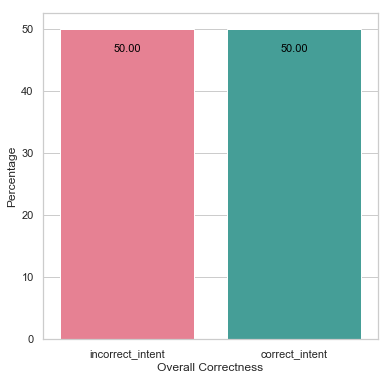

In [9]:
rcParams['figure.figsize'] = 6,6
ax1 = sns.barplot(x="correct_intent", y="correct_intent", 
                  data=results, estimator=lambda x: len(x) / len(results) * 100, 
                  palette="husl")
ax1.set(xticklabels=["incorrect_intent", "correct_intent"]) 
ax1.set(ylabel="Percentage")
ax1.set(xlabel="Overall Correctness")
for p in ax1.patches:
             ax1.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='black', xytext=(0, -20),
                 textcoords='offset points')

### Workspace Correctness
 = at least the workspace was correctly triggered

In [10]:
name_dict = {0:"incorrect_ws", 1:"correct_ws"}
results["correct_ws"].value_counts().rename(index=name_dict).to_dict()


{'correct_ws': 6, 'incorrect_ws': 2}

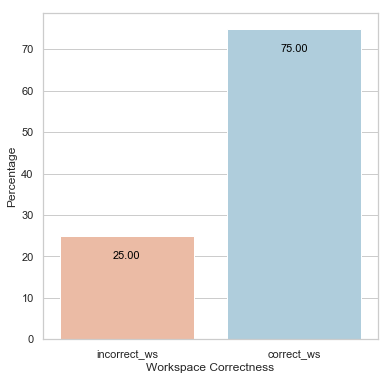

In [11]:
rcParams['figure.figsize'] = 6,6
ax1 = sns.barplot(x="correct_ws", y="correct_ws", 
                  data=results, estimator=lambda x: len(x) / len(results) * 100, 
                  palette="RdBu")
ax1.set(xticklabels=["incorrect_ws", "correct_ws"]) 
ax1.set(ylabel="Percentage")
ax1.set(xlabel="Workspace Correctness")
for p in ax1.patches:
             ax1.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='black', xytext=(0, -20),
                 textcoords='offset points')

----------------------------

### Focus on "correct_ws" correctness 
Let's focus on the "correct_ws" instances. (The workspace was correctly detected and the intent matching still needs to be evaluated). Here, we can apply the classical metrics. 

In [13]:
data = results.loc[results["correct_ws"]==1]

Confusion matrix for the Intent matching


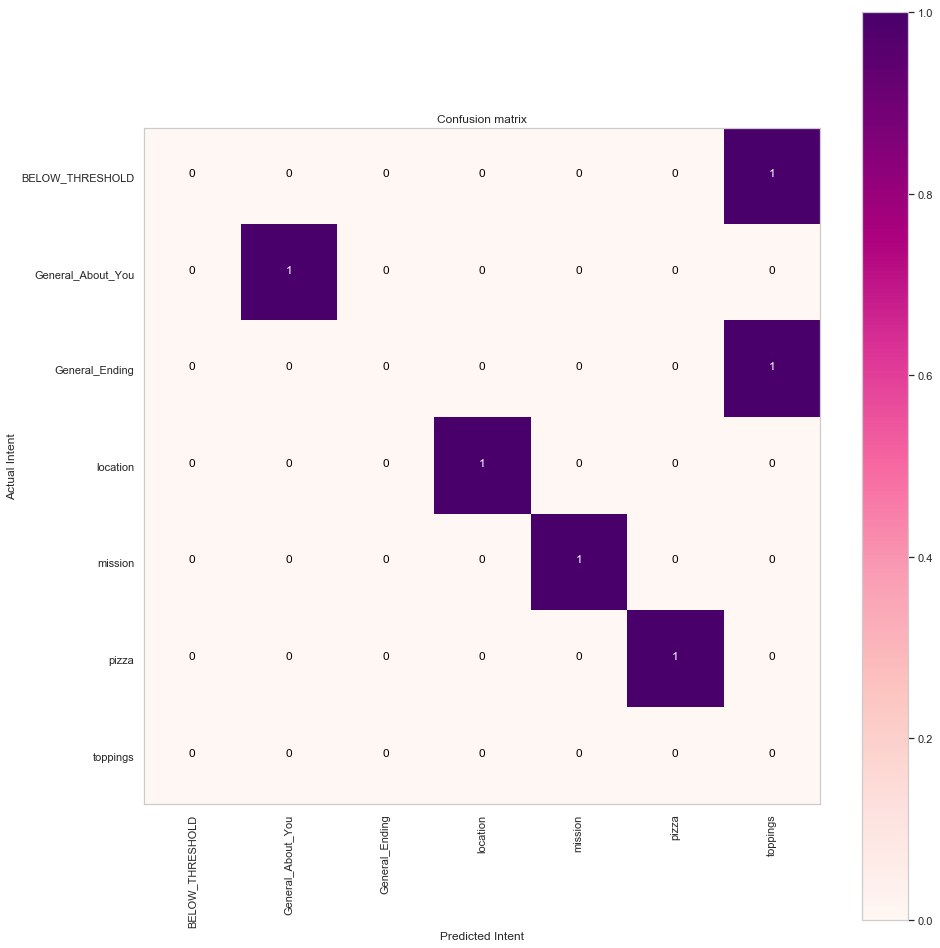

In [14]:
def data_prep(dataframe):
    """
    this function prepares the dataframe to be used 
    """
    dataframe["actual_intent_correct"] = [d.get('intent') for d in dataframe["max_confidence"]]
    dataframe["actual_intent_correct"] = np.where(([d.get('confidence')<threshold for d in dataframe["max_confidence"]]),\
                                                  "BELOW_THRESHOLD", dataframe["actual_intent_correct"])
    matrix = confusion_matrix(dataframe["actual_intent_correct"], dataframe["predicted_intent"])
    
    lab1 = dataframe["actual_intent_correct"].unique()
    lab2 = dataframe["predicted_intent"].unique()
    lab = np.union1d(lab1,lab2)
    
    return matrix, lab

matrix, lab = data_prep(data)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.RdPu):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix for the Intent matching")
    else:
        print('Confusion matrix for the Intent matching')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual Intent')
    plt.xlabel('Predicted Intent')
    plt.tight_layout()
    plt.grid(False)
    
    return 
    
plt.figure(figsize=(14,14))
plot_confusion_matrix(matrix, classes=lab,
                      title='Confusion matrix')



### Collection of Metrics

      
1. **Accuracy** : In multilabel classification, this function computes subset accuracy, the set of labels predicted for a sample must exactly match the corresponding set of labels in _y_true_.
2. **Precision** : The precision is the ratio _tp / (tp + fp)_ where tp is the number of _true positives_ and fp the number of _false positives_. The precision is intuitively the ability of the classifier not to label as positive a sample that is actually negative.
3. **Recall** : The recall is the ratio _tp / (tp + fn)_ where tp is the number of _true positives_ and fn the number of _false negatives_. The recall is intuitively the ability of the classifier to find all positive samples. 
4. **F-score** : The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0. The F-beta score weighs recall more than precision by a factor of beta. A value of beta == 1.0 means recall and precision are equally important.

[precision_recall_fscore_support function](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support)

In [15]:
print("OVERALL RESULTS")
accuracy = accuracy_score(data["actual_intent_correct"], data["predicted_intent"])
print("Accuracy:", accuracy)
precision,recall,fscore,support=precision_recall_fscore_support(data["actual_intent_correct"],
                                                                data["predicted_intent"],
                                                                average='weighted')
print("Precision:", precision)
print("Recall:", recall)
print("FScore:", fscore)

print("\n")
print("PER INTENT - DETAILED RESULTS")
print(classification_report(data["actual_intent_correct"], data["predicted_intent"]))

OVERALL RESULTS
Accuracy: 0.6666666666666666
Precision: 0.6666666666666666
Recall: 0.6666666666666666
FScore: 0.6666666666666666


PER INTENT - DETAILED RESULTS
                   precision    recall  f1-score   support

  BELOW_THRESHOLD       0.00      0.00      0.00         1
General_About_You       1.00      1.00      1.00         1
   General_Ending       0.00      0.00      0.00         1
         location       1.00      1.00      1.00         1
          mission       1.00      1.00      1.00         1
            pizza       1.00      1.00      1.00         1
         toppings       0.00      0.00      0.00         0

      avg / total       0.67      0.67      0.67         6



/Users/erikaagostinelli/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/erikaagostinelli/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/erikaagostinelli/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/erikaagostinelli/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samp

-------------------

## Analyse the Incorrect Matches 

We have identified 3 types of different incorrect matches. 
1. **Incorrect intent was triggered with high confidence**: It is important to understand why the incorrect intent is sensitive to the testing phrase – an N-gram test can be helpful in such cases. This type of error has the priority, since it can have a bad influence on the chatbot’s performance.
2. **Incorrect intent was triggered with low confidence** : Since those intents were triggered with low confidence, this error has less priority compared to problem (1). However, an incorrect intent was still detected. – an N-gram test can be helpful in such cases. Further, more training is necessary in order to boost the confidence level of the correct intent and resolving the conflicts between both intents.
3. **Correct intent but with low confidence** : More training is needed in order to increase the confidence level of the correct intent.

### 1. Incorrect intent was triggered with high confidence 

In [16]:
incorrect1 = data.loc[(data["predicted_intent"]!=data["actual_intent_correct"])]
if (len(incorrect1) == 0 ): 
    print ("No issues found")
else: 
    print("Detected: {} samples".format(len(incorrect1)))
    incorrect1.to_csv('./results/multi_workspace/01.wrong_intent_high_confidence.csv', index = False)
    print("File saved in 'results' - 01.wrong_intent_high_confidence.csv")

Detected: 2 samples
File saved in 'results' - 01.wrong_intent_high_confidence.csv


### 2. Incorrect intent was triggered with low confidence 

In [17]:
incorrect2 = data.loc[(data["correct_intent"]==0)&[d.get('confidence')<threshold for d in data["max_confidence"]]]
if (len(incorrect2) == 0 ): 
    print ("No issues found")
else: 
    print("Detected: {} samples".format(len(incorrect2)))
    incorrect2.to_csv('./results/multi_workspace/02.wrong_intent_low_confidence.csv', index = False)
    print("File saved in 'results' - 02.wrong_intent_low_confidence.csv")

Detected: 1 samples
File saved in 'results' - 02.wrong_intent_low_confidence.csv


### 3. Correct intent was triggered but with low confidence 

In [18]:
incorrect3 = data.loc[(data["correct_intent"]==1)&[d.get('confidence')<threshold for d in data["max_confidence"]]]
if (len(incorrect3) == 0 ): 
    print ("No issues found")
else: 
    print("Detected: {} samples".format(len(incorrect3)))
    incorrect3.to_csv('./results/multi_workspace/03.correct_intent_low_confidence.csv', index = False)
    print("File saved in 'results' - 03.correct_intent_low_confidence.csv")

No issues found


## Improvement List

- more analysis needed in "Workspace Correctness" 

------------------------------

### Author: 
- **[Erika Agostinelli](https://www.linkedin.com/in/erikaagostinelli/)** is a Data Scientist and AI specialist part of IBM Data Science Elite Team where she specializes in Analytics platforms and Machine Learning solutions.

Copyright 2019 IBM Corp. All Rights Reserved.